In [1]:
import json
import os
from tqdm import tqdm
import os
import requests
import pickle
import matplotlib.pyplot as plt
import numpy as np

## Load data

In [2]:
# path of blocks
SOURCE_PATH = '../../data/txn_data'
# SOURCE_PATH = 'testData'
# read files 
block_list = os.listdir(SOURCE_PATH)
sorted_block_list = [y for _, y in sorted([(int(a.split('.')[0]), a) for a in block_list])]
sorted_block_list = sorted_block_list
# print(sorted_block_list[:10])
print(f"There are {len(sorted_block_list)} blocks loaded")


def get_block_txn_list(block_json_file: str) -> dict:
    """
    @input: a block json file, e.g., 1111.json
    @output: a list of transaction in that block
    """
    json_path = os.path.join(SOURCE_PATH, block_json_file)
    f = open(json_path)
    json_data = json.load(f)
    tx = json_data['tx']
    f.close()
    return tx

There are 4087 blocks loaded


In [3]:
ADDRESS_REUSE_CODE = 0
CLUSTER_MEMBER_CODE = 1
UNKNOWN_CHANGE_CODE = 2
OVERLAY_APPLICATION_CODE = 3
TWO_OUTPUT_CODE = 2

with open('../../heuristic_data/address_reuse_transaction_address_list.pkl', 'rb') as f:
    address_reuse_transaction_address_list = pickle.load(f)

################################################################################################

with open('../../heuristic_data/overlay_application_transaction_address_list.pkl', 'rb') as f:
    overlay_application_transaction_address_list = pickle.load(f)

################################################################################################

with open('../../heuristic_data/transaction_candidate_list.pkl', 'rb') as f:
    transaction_candidate_list = pickle.load(f)

################################################################################################
with open('../../heuristic_data/transaction_address_summary.json') as f:
    transaction_address_summary = json.load(f)

################################################################################################
with open('../../heuristic_data/two_output_address_summary.json') as f:
    two_output_address_summary = json.load(f)

################################################################################################
with open('../../heuristic_data/clustering_member_list.pkl', 'rb') as f:
    clustering_member_list = pickle.load(f)

################################################################################################
with open('../../heuristic_data/unknown_change_list.pkl', 'rb') as f:
    unknown_change_list = pickle.load(f)

################################################################################################
with open('../../heuristic_data/clustering_candidate.json') as f:
    clustering_candidate = json.load(f)

################################################################################################
with open('../../heuristic_data/change_address_reuse_list.pkl', 'rb') as f:
    change_address_reuse_list = pickle.load(f)



print(f"Address reuse: {len(address_reuse_transaction_address_list):,}")
print(f"Cluster member: {len(clustering_member_list):,}")
print(f"Unknown change: {len(unknown_change_list):,}")
print(f"Overlay application: {len(overlay_application_transaction_address_list):,}")
# print(f"number of candidate transactions: {len(transaction_candidate_list):,}")

Address reuse: 1,231,860
Cluster member: 140,828
Unknown change: 4,002,971
Overlay application: 16,165


## Access cluster member transaction

In [4]:
check_cluster_member_dictionary = transaction_address_summary.copy()
for i in check_cluster_member_dictionary:
    check_cluster_member_dictionary[i] = 0
for i in clustering_member_list:
    check_cluster_member_dictionary[i] = 1

## Partition into 5 groups
- Unspent outputs
- Two change candidates
- Potential false positive
- Change address reuse 
- Final ground truth 

### 1. Unspent outputs

In [5]:
def if_unspent_output(txn: dict) -> bool:
    """
    @input: a transaction hash
    @output: True if it's a unspent transaction; False otherwise
    """
    for output in txn["out"]:
        if output["spent"] == False:
            return True
    return False

### 2. Two change candidates

In [6]:
def if_two_change_candidates(txn: dict) -> bool:
    """
    @input: one transaction, stored as dictionary
    @output: True if at least one output is in the same base cluster as the inputs
    """
    ########################################################################
    # extract a transaction's input and output
    input_list = []
    output_list = []
    for input_ in txn["inputs"]:
        input_list.append(input_["prev_out"]["addr"])
    for output in txn["out"]:
        if "addr" in output:
            output_list.append(output["addr"])
    ########################################################################

    ########################################################################
    input_cluster = clustering_candidate[input_["prev_out"]["addr"]]
    if input_cluster == -1:
        return False
    else:
        output_counter = 0
        """counter for checking if at least one output is in the same base cluster as the inputs"""
        for out_ in output_list:
            if clustering_candidate[out_] == input_cluster:
                output_counter += 1
        if output_counter == 2:
            return True
        else:
            return False
    ########################################################################

#### Collect unspent __output transaction__ and __two change candidate__ transaction

In [7]:
unspent_output_list = []
two_change_candidate_list = []

for block_json_file in tqdm(sorted_block_list[:]):
    # get transaction list of that block
    txns_list = get_block_txn_list(block_json_file)

    for txn in txns_list:
        txn_hash = txn['hash']
        # txn_time = txn['time']
        
        if check_cluster_member_dictionary[txn_hash]:
            if if_unspent_output(txn):
                unspent_output_list.append(txn_hash)
            if if_two_change_candidates(txn):
                two_change_candidate_list.append(txn_hash)


print(f"Unspent output: {len(unspent_output_list):,}")
print(f"Two change candidates: {len(two_change_candidate_list):,}")

100%|██████████| 4087/4087 [06:43<00:00, 10.13it/s]

Unspent output: 2,382
Two change candidates: 523


#### Remove transactions with __unspent output__ issue and __two change candidate__ issue

In [8]:
ground_truth_list = list(set(clustering_member_list)\
                         .difference(set(unspent_output_list))\
                         .difference(set(two_change_candidate_list))\
                         .difference(set(change_address_reuse_list)))

### 3. Potential false positive

In [9]:
def if_mt_gox(txn: dict) -> bool:
   """
   @input: one transaction, stored as dictionary
   @output: True if the transaction belongs to the Mt. Gox supercluster
   """
   return False

In [10]:
ground_truth_clustering = {}
ground_truth_list_hash = {}
for i in ground_truth_list:
    ground_truth_list_hash[i] = 1

# filter clustering
input_list = []
output_list = []
for block_json_file in tqdm(sorted_block_list[:]):
    # get transaction list of that block
    txns_list = get_block_txn_list(block_json_file)

    for txn in txns_list:
        txn_hash = txn['hash']
        
        # filter transactons only from the ground_truth_list
        try:
            _ = ground_truth_list_hash[txn_hash]
        except KeyError:
            continue
        
        # collect clustering information to ground_truth_clustering
        for input_ in txn['inputs']:
            input_addr = input_['prev_out']['addr']
            ground_truth_clustering[input_addr] = clustering_candidate[input_addr]
        for output in txn['out']:
            if 'addr' in output:
                output_addr = output['addr']
                ground_truth_clustering[output_addr] = clustering_candidate[output_addr]

100%|██████████| 4087/4087 [06:46<00:00, 10.05it/s]


In [11]:
print(f"There are {len(ground_truth_list):,} transactions in the ground truth set")
print(f"There are {len(set(ground_truth_clustering.values())):,} clusters in the ground truth set")
print(f"There are {len(ground_truth_clustering):,} address in the ground truth set")
print('-' * 55)
print(f"There are {len(set(clustering_candidate.values())):,} clusters in total")
print(f"There are {len(clustering_candidate):,} addresses in total")

There are 86,882 transactions in the ground truth set
There are 46,687 clusters in the ground truth set
There are 591,629 address in the ground truth set
-------------------------------------------------------
There are 3,317,719 clusters in total
There are 11,341,115 addresses in total


In [12]:
ground_truth_clustering_reverse = {}
"""
@key: cluster id
@value: a list of address in that cluster
"""
# initialize the reverse clustering 
for cluster in list(set(ground_truth_clustering.values())):
    ground_truth_clustering_reverse[cluster] = []

# add address to ground_truth_clustering_reverse
for address in tqdm(ground_truth_clustering):
    ground_truth_clustering_reverse[ground_truth_clustering[address]].append(address)


100%|██████████| 591629/591629 [00:00<00:00, 2109503.18it/s]


In [13]:
with open('../../heuristic_data/ground_truth_clustering_reverse.json', 'w') as f:
    json.dump(ground_truth_clustering_reverse, f)

In [14]:
ground_truth_clustering_reverse

{2883584: ['3Ebvg5ib1r9sF1JayNQcQXzmXM5rxGtrvV'],
 4: ['3PsDCizUqXJZiv6H9PwyiGGQh6Bg5DQtLT',
  '3HrifS4eLcYx5UuxTy1pyp853bG37ZbRdZ',
  '3JhczxNgaRctVRFHevVW5yWeygAEZVhWQj',
  '3DpUcog5ZXCdFwY4dV6uhNoNRWmzYbMK5q',
  '3PwtDoALAiNAWrMnq5f5SnxQF3VZUuqQRf',
  '3Q2dRnPwMKEWUtCMjw3oBrN6F762AfkSgj',
  '399vyqiAVwAwsFVNV7MAEDqVsrxwsnTUVs',
  '3FrBXaQHqKJK5gLdb59eBWRzASkCDDUfiL',
  '3MiKRMKZ8cnZD6PUmCD2EVu6dSwMeoM9a7',
  '3HZdacGTDVcWwjwKCb7sEoD3kVTxJ7d25P',
  '3KHq3tXhxa5v4sggNQ2mqsnSsft87Ctsrj'],
 131076: ['1FGc9X5W6oSEPSu4XnJvSDcExzhqMnaHad',
  '1CxVBtyynQ3jCpuWus6FF1qh1bL9eNgxMq',
  '1LtV636eGZMVYmamP8iz4DaxF1B9eJuYvY',
  '1CwAxe5yiCV43vq82w67xVdn4FRcPqz8v7',
  '16VKnA7oBu7JYufheV6z2aP6yhCajnm67Y',
  '1429jQ61RvkTrk3zRrAwKmEeici9phgVEi',
  '1JJ53Zr4fFAGaJhkodpebdrCh5gnHcWauo',
  '1HiLtNvF1RhnS5jrA1VF6pLa4NGHLj9RFc',
  '1Njc54wcTvrsqXbhK4Msnc2kKRR5DqdfBG',
  '179yfu3QoyzVed1EkdjrkqLreCD7aFxkhK',
  '1MjpgT8e3R1J7Xb6HodM6hMd6WxBfqLxbv'],
 1703940: ['1Axs3XWXLd6gRnZyfsmQGwR5nZjjxxoJyS'],
 6: ['3

In [15]:

# for pairs (x, y) in cluster_size_list
# x := size of the cluster
# y := id of the cluster
cluster_size_lst = sorted([(len(ground_truth_clustering_reverse[cluster_id]), cluster_id) for cluster_id in set(ground_truth_clustering.values())])[::-1]


In [16]:
cluster_size_lst

[(35240, -1),
 (19231, 2977),
 (18969, 2979),
 (10464, 2946),
 (9076, 546395),
 (7961, 1020069),
 (7433, 6797),
 (7031, 2898),
 (6977, 2939),
 (6221, 6814),
 (6063, 21021),
 (5809, 21365),
 (5553, 2943),
 (5548, 37518),
 (5396, 21022),
 (5374, 2961),
 (5347, 21017),
 (5315, 2950),
 (5311, 7343),
 (5206, 7359),
 (5132, 2925),
 (5094, 21015),
 (4913, 13455),
 (4900, 1381904),
 (4884, 2978),
 (4807, 7360),
 (4747, 6799),
 (4650, 6801),
 (4581, 1723939),
 (4581, 7350),
 (4550, 44397),
 (4524, 7351),
 (4482, 21019),
 (4472, 6812),
 (4458, 7342),
 (4457, 2944),
 (4447, 2941),
 (4125, 2909),
 (4100, 7341),
 (3912, 2938),
 (3900, 21016),
 (3833, 7356),
 (3654, 7354),
 (3476, 2964),
 (3463, 2419674),
 (3268, 6803),
 (3261, 28169),
 (3244, 2913),
 (3200, 7347),
 (3114, 1853822),
 (3096, 2942),
 (3046, 2945),
 (3010, 2963),
 (2959, 6815),
 (2932, 174571),
 (2932, 7329),
 (2766, 2914),
 (2750, 2899),
 (2685, 99272),
 (2657, 7353),
 (2653, 7339),
 (2627, 74923),
 (2614, 2998),
 (2586, 7349),
 (2568

In [17]:
top_100_cluster_id = []
for _, cluster_id in cluster_size_lst[1:101]:
    top_100_cluster_id.append(cluster_id)

top_100_address = []
for i in top_100_cluster_id:
    top_100_address = top_100_address + ground_truth_clustering_reverse[i]
print(f"There are {len(top_100_address)} addresses in top 100 largest base clusters")

rng = np.random.default_rng(seed=42)
index_list = rng.integers(low=0, high=len(top_100_address), size = 25)
random_25_address = []
for index_ in index_list:
    random_25_address.append(top_100_address[index_])

for i in random_25_address:
    print(i)

There are 373225 addresses in top 100 largest base clusters
14jJwC73WTsneUn42RD3eTDPnHouxHxtXV
3HHPtwWNcnZT2g4jiN22SDF9dGWd2omTVh
18mdGXM5EPaZn34g8DtL17QG8Hy4MrvSUC
168mVFcvmxTeMSqjKHVUJ6HNHZA31MJic8
1DmBMAnK4iMUrxT3rUznzP7TQ7CTEdit1A
159ZcsfWGihYeyQ14m7LbVwGexVz7rqvSV
1AQGsrd57UZYvcmmvPzLiGRFdJNof8HNhe
1PYukoVy8qmcquKfsVYugPC99dNN9ee9jo
1Q3iuhovm1VS5CwQte2ksqBdQE8ZciBgQV
1DCNPeepKHwC9Fo7ETGESTWLYEVPfoMiAN
1GLAeUYPKNEYjXKbkoYiJXC7Cno8FKQn5P
35ABaj1jFypo6Xaybyy3VHc3j7uGeqfDpG
1E5GBh6tivjs8YHWhkAMqR3QRVC4cFRn3o
1B1jUmjYyhWrDA72BQRZm5Qdcby217UL3H
1CB5fkUJMHHsr1DrABuKvFLSL7VVv6f15z
1HPXUMkHtzyVCkLy1gVXMEg6wn63bu9jND
1J88rtVrqhm6VekdWxcFLPZ43ZQFbHX2ZB
19g7ymAc4c5o5UBKJcuBAJyFFf4fPkN7Pd
17ry4rXseBT4sig71zDyCDb86mk7b6acbj
1BoB5jJHo2mC2DMGNzLyuZjGhv1QKeuozB
3CS7ESLJd6DDth363cdGgqFBMv2yio2wCo
1QJN2Zmu7SvQ7UR3FzQrRaff9g5ANLfbuh
1GB3fSeVxxoBmrhecVaNuUy6TRubbmrj4Z
3FC1cfzqjZEEcETLDGunXGE2XQPGVP6vZN
13MwBLDtvLhf64WoHHYgC4H7HDwhGzXR19


In [18]:
# random_25_address_label = {}
# random_25_address_label['14jJwC73WTsneUn42RD3eTDPnHouxHxtXV'] = '0000a252f0' -
# random_25_address_label['3HHPtwWNcnZT2g4jiN22SDF9dGWd2omTVh'] = '0000de0c6d'
# random_25_address_label['18mdGXM5EPaZn34g8DtL17QG8Hy4MrvSUC'] = '000043c2da'
# random_25_address_label['168mVFcvmxTeMSqjKHVUJ6HNHZA31MJic8'] = '0000a781da' x
# random_25_address_label['1DmBMAnK4iMUrxT3rUznzP7TQ7CTEdit1A'] = '00015298c6'
# random_25_address_label['159ZcsfWGihYeyQ14m7LbVwGexVz7rqvSV'] = '0000773978'
# random_25_address_label['1AQGsrd57UZYvcmmvPzLiGRFdJNof8HNhe'] = '0000a252f0' -
# random_25_address_label['1PYukoVy8qmcquKfsVYugPC99dNN9ee9jo'] = '00005709b1'
# random_25_address_label['1Q3iuhovm1VS5CwQte2ksqBdQE8ZciBgQV'] = '0000f8e256' 
# random_25_address_label['1DCNPeepKHwC9Fo7ETGESTWLYEVPfoMiAN'] = '0000a252f0' -
# random_25_address_label['1GLAeUYPKNEYjXKbkoYiJXC7Cno8FKQn5P'] = '0000a5d197'
# random_25_address_label['35ABaj1jFypo6Xaybyy3VHc3j7uGeqfDpG'] = '00000e4cda' 
# random_25_address_label['1E5GBh6tivjs8YHWhkAMqR3QRVC4cFRn3o'] = '000017e2bc'
# random_25_address_label['1B1jUmjYyhWrDA72BQRZm5Qdcby217UL3H'] = '000041c8c6'
# random_25_address_label['1CB5fkUJMHHsr1DrABuKvFLSL7VVv6f15z'] = '00011cbc1c'
# random_25_address_label['1HPXUMkHtzyVCkLy1gVXMEg6wn63bu9jND'] = '00000e6843'
# random_25_address_label['1J88rtVrqhm6VekdWxcFLPZ43ZQFbHX2ZB'] = '0001460430'
# random_25_address_label['19g7ymAc4c5o5UBKJcuBAJyFFf4fPkN7Pd'] = '0000e3a3b8'
# random_25_address_label['17ry4rXseBT4sig71zDyCDb86mk7b6acbj'] = '0000011bd9' a
# random_25_address_label['1BoB5jJHo2mC2DMGNzLyuZjGhv1QKeuozB'] = '0000a781da' x
# random_25_address_label['3CS7ESLJd6DDth363cdGgqFBMv2yio2wCo'] = '00004d0d98'
# random_25_address_label['1QJN2Zmu7SvQ7UR3FzQrRaff9g5ANLfbuh'] = '0000efb497'
# random_25_address_label['1GB3fSeVxxoBmrhecVaNuUy6TRubbmrj4Z'] = '000170ef5f'
# random_25_address_label['3FC1cfzqjZEEcETLDGunXGE2XQPGVP6vZN'] = '00000bc42e'
# random_25_address_label['13MwBLDtvLhf64WoHHYgC4H7HDwhGzXR19'] = '0000011bd9' a

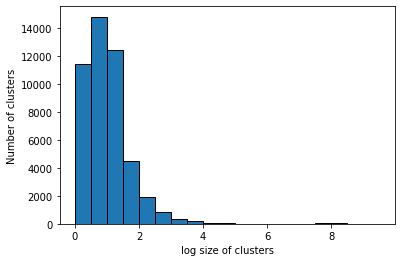

In [19]:
plt.hist([np.log(x) for (x, _) in cluster_size_lst[1:]], 
         bins=np.arange(0, 10, 0.5),
         edgecolor = 'black')
plt.xlabel("log size of clusters")
plt.ylabel("Number of clusters")
plt.show()

## Store _ground_truth_list_ into _../heuristic_data/..._

In [20]:
with open('../../heuristic_data/ground_truth_list.pkl', 'wb') as f:
    pickle.dump(ground_truth_list, f)

In [21]:
len(ground_truth_list)

86882

## Check clustering

In [22]:
max(clustering_candidate.values())

3326803

In [23]:
ground_truth_clustering = {}
ground_truth_list_hash = {}
for i in ground_truth_list:
    ground_truth_list_hash[i] = 1

In [24]:
input_list = []
output_list = []
for block_json_file in tqdm(sorted_block_list[:]):
    # get transaction list of that block
    txns_list = get_block_txn_list(block_json_file)

    for txn in txns_list:
        txn_hash = txn['hash']
        
        # filter transactons only from the ground_truth_list
        try:
            _ = ground_truth_list_hash[txn_hash]
        except KeyError:
            continue
        
        # collect clustering information to ground_truth_clustering
        for input_ in txn['inputs']:
            input_addr = input_['prev_out']['addr']
            ground_truth_clustering[input_addr] = clustering_candidate[input_addr]
        for output in txn['out']:
            if 'addr' in output:
                output_addr = output['addr']
                ground_truth_clustering[output_addr] = clustering_candidate[output_addr]

100%|██████████| 4087/4087 [07:38<00:00,  8.92it/s]


In [25]:
len(ground_truth_clustering)

591629

In [26]:
def find_txn_from_single_address(address: str) -> str:
    for block_json_file in tqdm(sorted_block_list[:]):
        # get transaction list of that block
        txns_list = get_block_txn_list(block_json_file)

        for txn in txns_list:
            txn_hash = txn['hash']
            # filter transactons only from the ground_truth_list
            try:
                _ = ground_truth_list_hash[txn_hash]
            except KeyError:
                continue
            
            # collect clustering information to ground_truth_clustering
            for input_ in txn['inputs']:
                input_addr = input_['prev_out']['addr']
                if input_addr == address:
                    print("input:")
                    return txn_hash
            for output in txn['out']:
                if 'addr' in output:
                    output_addr = output['addr']
                    if output_addr == address:
                        print("output")
                        return txn_hash

In [27]:
ground_truth_clustering['bc1q8s78mq5ser7v2098wq55n8sp77u0uaar8ujad7']

131282